In [1]:
import math
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (8, 6) # 修改plt默认图片大小

pd.set_option('display.float_format',lambda x: f"{x:,.2f}")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)

from IPython.display import display, HTML
# display(HTML(data.to_html(index = False)))

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 加载训练集
为了简化，预处理时删掉了很多变量并把所有object变量转为数值；填充了null

In [2]:
df = pd.read_csv('../data/titanic/train_treated.csv')
df_x = df.drop(['Survived'], axis=1)
df_y = df['Survived']

潦草地预览一下数据

In [3]:
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,713.00,713.00,713.00,713.00,713.00,713.00,713.00,713.00
mean,0.38,2.32,0.35,29.53,0.53,0.39,31.83,0.37
std,0.49,0.83,0.48,13.09,1.14,0.82,50.11,0.66
min,0.00,1.00,0.00,0.67,0.00,0.00,0.00,0.00
25%,0.00,2.00,0.00,22.00,0.00,0.00,7.92,0.00
50%,0.00,3.00,0.00,28.75,0.00,0.00,14.45,0.00
75%,1.00,3.00,1.00,35.00,1.00,0.00,31.27,1.00
max,1.00,3.00,1.00,80.00,8.00,6.00,512.33,3.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  713 non-null    int64  
 1   Pclass    713 non-null    int64  
 2   Sex       713 non-null    int64  
 3   Age       713 non-null    float64
 4   SibSp     713 non-null    int64  
 5   Parch     713 non-null    int64  
 6   Fare      713 non-null    float64
 7   Embarked  713 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 44.7 KB


In [5]:
train_x, test_x, train_y, test_y = train_test_split(df.drop('Survived', axis = 1), df['Survived'], test_size=0.2)

# 训练一个决策树模型
精度能看就好，这里树模型是用来拟合归因的。gridsearch可以省略，只是习惯性网格调了下参。现在hyperopt用的多一点，bayes搜的更快

In [6]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

# 随便网格搜索最优化参数
gini_thresholds = np.linspace(0,0.5,20)
parameters = {'splitter':('best','random'),
              'criterion':("gini","entropy"),
              "max_depth":[*range(1,10)],
              'min_samples_leaf':[*range(1,50,5)],
              'min_impurity_decrease':[*gini_thresholds]}
clf = tree.DecisionTreeClassifier(random_state=25)
# 其实这里用acc比较好，
GS = GridSearchCV(clf, parameters, cv=3, scoring='roc_auc')
GS.fit(train_x, train_y)
# 搜出来的最佳参数
print(GS.best_params_)
print(GS.best_score_)

{'criterion': 'gini', 'max_depth': 3, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 6, 'splitter': 'best'}
0.8442415017757483


In [7]:
# 保存模型
import pickle
filename = 'dtree_progress.model'
pickle.dump(GS.best_estimator_, open(filename, 'wb')) 

# 查看树模型在测试数据上效果

In [8]:
# 加载保存了的模型
model = pickle.load(open(filename, 'rb'))

In [9]:
pred_y = model.predict_proba(test_x)[:, 1]

In [10]:
roc_auc_score(test_y, pred_y)

0.8123179359134417

# 归因

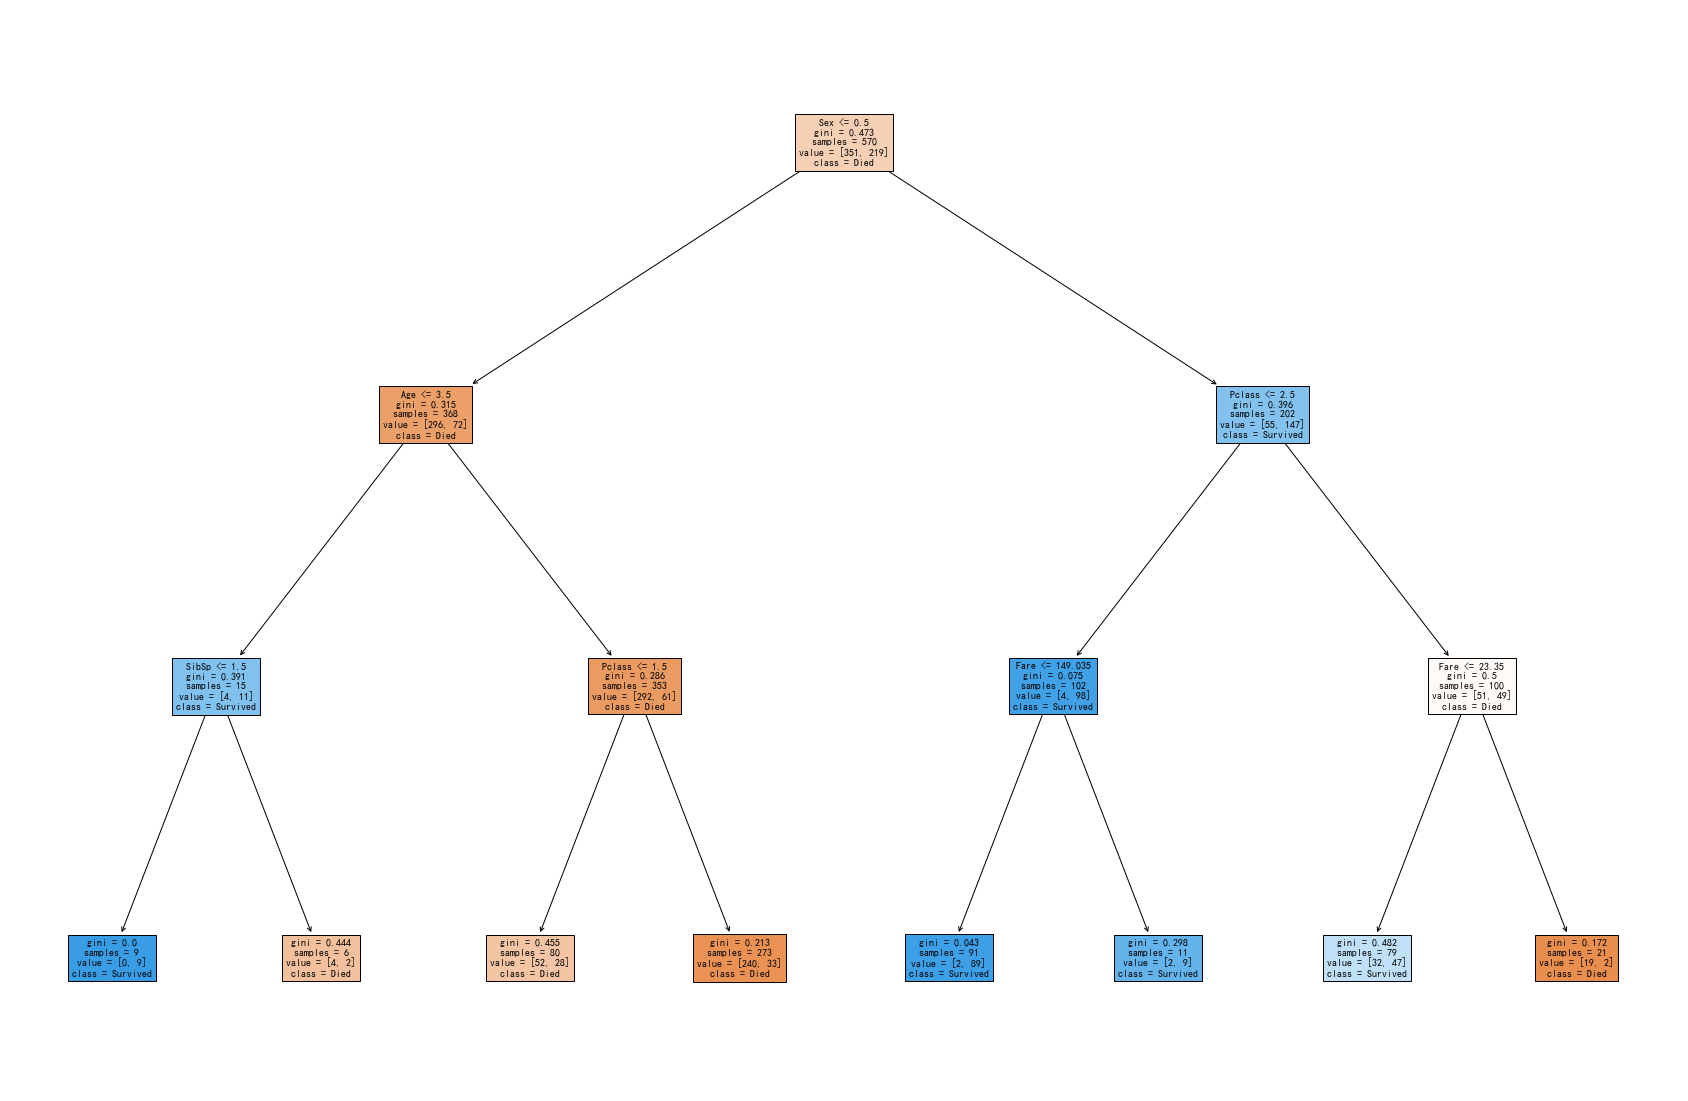

In [11]:
fig = plt.figure(figsize=(30,20))
_ = tree.plot_tree(GS.best_estimator_, 
                   feature_names=df_x.columns.values.tolist(),  
                   class_names= ['Died', 'Survived'],
                   filled=True,
                   fontsize = 10)
# 阅读方式：越上面的特征越重要
plt.show()